<a href="https://colab.research.google.com/github/teoalcdor/trabajo_iae/blob/main/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter01/Back_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Clasificación

Para la tarea de clasificación vamos a utilizar el modelo VGG19. Lo descargaremos ya pre-entrenado, y le haremos *finetuning* y *transfer learning*, congelando todos los pesos de todas las capas salvo la penúltima y última. Cambiamos la última capa para adaptarla al número de clases de nuestro *dataset*.

## Librerías

In [ ]:
!pip install torchinfo

In [ ]:
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms, datasets
from torchvision.models import vgg19, VGG19_Weights
from tqdm import tqdm
import copy

## Dispositivo

Si podemos, usamos la GPU, si no, la CPU:

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Funciones Auxiliares

In [ ]:
def train_batch(x, y, model, optimizer, loss_fn):
    """
    Entrena el modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    prediction = model(x)

    # Obtenemos la perdida
    batch_loss = loss_fn(prediction, y.long())

    # Calculamos el gradiente de la perdida con retropropagacion
    batch_loss.backward()

    # Hacemos un paso del metodo del gradiente
    optimizer.step()

    # Vaciamos el optimizador de la informacion del gradiente
    optimizer.zero_grad()

    return batch_loss.item() # Retornamos el numero, no un tensor

@torch.no_grad()
def accuracy(x, y, model):
    """
    Calcula la accuracy del modelo en un batch.
    """

    model.eval() # Modo inferencia

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    prediction = model(x)

    # Obtenemos la clase de la prediccion y vemos si es correcta
    _, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist() # El batch da lugar a un vector de predicciones

@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    """
    Calcula la pérdida del modelo en el conjunto de validación.
    """

    model.eval() # Modo inferencia

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    prediction = model(x)

    # Obtenemos la perdida
    val_loss = loss_fn(prediction, y.long())

    return val_loss.item() # Retornamos el numero, no un tensor

def train_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=15):
    """
    Entrena el modelo, implementando un mecanismo que actúa como early stopping basado en
    la accuracy en validación. Devuelve también las pérdida y accuracy encontradas en
    los conjuntos de entrenamiento y valiación durante el entrenamiento.
    """

    # Inicializamos las listas con las perdidas y accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Inicializamos el mecanismo de early stopping
    max_val_accuracy = -1
    best_model = {
        "model_state_dict": None,
        "optimizer_state_dict": None,
        "epoch": None,
        "max_val_accuracy": None
    }

    for epoch in range(epochs):

        # Regristramos el momento de comienzo de la epoch
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                          time.strftime("%y %m %d %H %M %S")
                                          .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"
        start = time.time()
        print("=" * 80)
        print(f"Epoch: {epoch + 1} - Started: {time_stamp}")

        # Inicializamos las listas con las perdidas y accuracies de la epoch
        train_epoch_losses, train_epoch_accuracies = [], []
        val_epoch_losses, val_epoch_accuracies = [], []

        # Entrenamos el modelo con minibatch
        _n = len(train_dataloader)
        for batch in tqdm(train_dataloader, total=_n, desc="- Training Loss"):
            x, y = batch
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)
        train_epoch_loss = np.array(train_epoch_losses).mean() # Aproximacion de la perdida en entrenamiento

        # Calculamos la accuracy sobre el conjunto de entrenamiento
        for ix, batch in tqdm(enumerate(train_dataloader), total=_n, desc="- Training Accuracy"):
            x, y = batch
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)
        train_epoch_accuracy = np.mean(train_epoch_accuracies) # Aproximacion de la accuracy en entrenamiento

        # Calculamos la perdida y la accuracy sobre el conjunto de validacion
        _n = len(val_dataloader)
        for ix, batch in tqdm(enumerate(val_dataloader), total=_n, desc="- Validation Loss and Accuracy"):
            x, y = batch
            val_is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)
            validation_loss = val_loss(x, y, model, loss_fn)
            val_epoch_losses.append(validation_loss)
        val_epoch_loss = np.mean(val_epoch_losses) # Aproximacion de la perdida en validacion
        val_epoch_accuracy = np.mean(val_epoch_accuracies) # Aproximacion de la accuracy en validacion

        # Actualizamos las perdidas y accuracies
        train_losses.append(train_epoch_loss)
        val_losses.append(val_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_accuracies.append(val_epoch_accuracy)

        # Ponemos en marcha el mecanismo de early stopping
        if val_epoch_accuracy > max_val_accuracy:
            best_model["model_state_dict"] = copy.deepcopy(model.state_dict())
            best_model["optimizer_state_dict"] = copy.deepcopy(optimizer.state_dict())
            best_model["epoch"] = epoch
            best_model["max_val_accuracy"] = val_epoch_accuracy
            max_val_accuracy = val_epoch_accuracy

        # Regristramos el momento de comienzo de la epoch
        end = time.time()
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                        time.strftime("%y %m %d %H %M %S")
                                        .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"

        print(f"Epoch: {epoch + 1} - Ended: {time_stamp} - Duration: {round(end - start, 2)}s")
        print()

        # Imprimimos estadisticas de la epoch para un mejor seguimiento
        print(f"Training Loss: {train_losses[-1]} - Validation Loss: {val_losses[-1]}")
        print(f"Training Accuracy: {train_accuracies[-1]} - Validation Accuracy: {val_accuracies[-1]}")
        print("=" * 80)
        print()

    return train_losses, train_accuracies, val_losses, val_accuracies, best_model

def prediction_step(model, inputs):
    """
    El modelo predice sobre una imagen.
    """

    model.eval() # Modo inferencia
    data = inputs[0] # Seleccionamos la imagen
    outputs = model(data) # Propagacion hacia delante
    _, pred = torch.max(outputs.data , 1) # Prediccion
    return pred

def predict(model, dataloader):
    """
    Permite predecir sobre todas las imágenes de un dataloader.
    """

    num_elements = len(dataloader.dataset)
    num_batches = len(dataloader)
    batch_size = dataloader.batch_size
    predictions = torch.zeros(num_elements)

    # Predecimos por batches
    for i, batch in enumerate(dataloader):
        start = i * batch_size
        end = start + batch_size
        if i == num_batches - 1:
            end = num_elements
        pred = prediction_step(model, batch)
        predictions[start:end] = pred

    return predictions.cpu().numpy()

def plot_training_results_classification(
    train_accuracies, val_accuracies,
    train_losses, val_losses, title):
    """
    Representa la pérdida y accuracy del modelo en el entrenamiento sobre
    los conjuntos de entrenamiento y validación.
    """

    # Diccionario con las perdidas
    losses_results = pd.DataFrame(
        {"Entrenamiento": train_losses,
         "Validación": val_losses})

    # Diccionario con las accuracies
    accuracies_results = pd.DataFrame(
        {"Entrenamiento": train_accuracies,
         "Validación": val_accuracies})

    with sns.axes_style("whitegrid"):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

        # Grafica de las perdidas
        losses_results_plot = sns.lineplot(data=losses_results, ax = axs[0])
        axs[0].set_ylabel("Pérdida", fontsize=17)
        axs[0].set_xticks([0, 4, 9, 14])
        axs[0].set_xticklabels([1, 5, 10, 15], fontsize=14)
        axs[0].tick_params(axis='y', labelsize=14)
        axs[0].legend(fontsize=11)

        # Grafica de las accuracies
        accuracies_results_plot = sns.lineplot(data=accuracies_results, ax = axs[1])
        axs[1].set_xticks([0, 4, 9, 14])
        axs[1].set_xticklabels([1, 5, 10, 15], fontsize=14)
        axs[1].set_ylabel("Accuracy", fontsize=17)
        axs[1].set_xlabel("Epochs", fontsize=17)
        axs[1].tick_params(axis='y', labelsize=14)
        axs[1].legend(fontsize=11)

        fig.suptitle(title, fontsize=20)
        plt.tight_layout()
        plt.show()

def make_cf_matrix(predictions, true_values, label_encoder, title):
    """
    Representa y devuelve la matriz de confusión de un modelo.
    """

    # Calculamos la matriz de confusion
    cf_matrix = confusion_matrix(true_values, predictions)

    # Calculamos los porcentajes por fila
    cf_matrix_percentage = cf_matrix / cf_matrix.sum(axis=1).reshape(-1, 1)

    # Convertimos la matriz a DataFrame por comididad (para nombres de fila y columna)
    df_cf_matrix = pd.DataFrame(cf_matrix)

    # Asignamos a cada fila y columna sus nombres
    df_cf_matrix.index = label_encoder.classes_
    df_cf_matrix.columns = label_encoder.classes_

    # Hacemos lo mismo con la matriz de porcentajes
    df_cf_matrix_percentage = pd.DataFrame(cf_matrix_percentage)
    df_cf_matrix_percentage.index = label_encoder.classes_
    df_cf_matrix_percentage.columns = label_encoder.classes_

    # Formateamos los valores absolutos de cada celdilla
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

    # Formateamos los porcentajes de cada celdilla
    group_percentages = ["{0:.2%}".format(value) for value in (
        cf_matrix_percentage).flatten()]

    # A partir de los valores formateados hacemos las etiquetas
    cf_labels = np.asarray([
        f"{v1}\n{v2}" for v1, v2 in
        zip(group_counts, group_percentages)
    ]).reshape(len(label_encoder.classes_), len(label_encoder.classes_))

    # Representamos la matriz de confusion
    sns.set_context("paper")
    fig, ax = plt.subplots(figsize=(7, 7))
    cf_plot = sns.heatmap(df_cf_matrix_percentage,
                annot=cf_labels,
                cmap="Blues", fmt="", linewidth=0.5, linecolor = "white", cbar=False, annot_kws={"size": 12}, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Predicción", fontsize=18)
    ax.set_ylabel("Verdadera Clase", fontsize=18)
    plt.tight_layout()
    plt.show()

    return df_cf_matrix, df_cf_matrix_percentage

## Datos

Montamos nuestra unidad de Google Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Descomprimimos los datos:

In [ ]:
zip_path = "/content/drive/MyDrive/trabajo_iae/datasets/classification_dataset_augmented.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Comprobamos la estructura del dataset de etiquetas:

In [ ]:
val_labels = pd.read_csv("/content/classification_dataset_augmented/val_labels.csv")
train_labels = pd.read_csv("/content/classification_dataset_augmented/train_labels.csv")

Instanciamos el  el LabelEncoder, para trabajar con mayor comodidad con las etiquetas:

In [ ]:
label_encoder = LabelEncoder()

# Forzamos las clases en el LabelEncoder para que coincidan
# con las del dataset creado.
label_encoder.classes_ = np.array([
    'civilian aircraft',
    'civilian car',
    'military aircraft',
    'military helicopter',
    'military tank',
    'military truck'
])

Definimos la transformación estándar por la que tienen que pasar las imagenes para que las podamos introducir en el modelo:

In [ ]:
standard_transform = transforms.Compose([
    transforms.ToPILImage(), # Pasamos a formato PIL
    transforms.Resize((224, 224)), # Redimensionamos
    transforms.ToTensor(), # Pasamos a tensor de Pytorch y normalizamos a [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizacion de Pytorch
])

Creamos la clase de nuestros *datasets* para esta tarea:

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, img_labels, folder, transform=None):
        self.y = img_labels["object_class"]
        self.files = img_labels["filename"]
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, ix):
        # Seleccionamos la imagen y la leermos
        nombre = self.files.iloc[ix]
        path = f"{self.folder}{nombre}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Seleccionamos la clase
        target = self.y.iloc[ix]

        return image, target


    def collate_fn(self, batch):
        images, targets = tuple(zip(*batch))

        # Transformamos las imagenes si procede
        if self.transform is not None:
            images = [self.transform(image)[None] for image in images]

        # Concatenamos las imagenes en un tensor 4-dimensional por la primera dim
        images = torch.cat(images, dim=0)

        # Pasamos las etiquetas a long para poder usar las funciones de perdida de Pytorch
        targets = torch.tensor(targets).long()

        return images.to(DEVICE), targets.to(DEVICE)

Instanciamos la clase del *dataset* y del *dataloader*:

In [ ]:
# Conjunto de entrenamiento
train_dataset = ClassificationDataset(
    train_labels,
    "/content/classification_dataset_augmented/images/", # "datasets/classification_dataset_agumented/images/"
    standard_transform
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    collate_fn=train_dataset.collate_fn
)

# Conjunto de validacion
val_dataset = ClassificationDataset(
    val_labels,
    "/content/classification_dataset_augmented/images/", # "datasets/classification_dataset_agumented/images/"
    standard_transform
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    collate_fn=val_dataset.collate_fn
)

## Modelo

Echamos un vistazo al modelo:

In [ ]:
model_vgg19 = vgg19(weights=VGG19_Weights.DEFAULT)
summary(model_vgg19, input_size=(1,3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 79.4MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

Definimos una función que congele todas los pesos de las capas del modelo salvo la penúltima y adapte la última, también con pesos descongelados:

In [ ]:
def get_model_vgg19(num_classes):
    """
    Nos permite obtener un modelo VGG19 listo para aplicar fine tuning y transfer learning,
    su optimizador (Adam) y la funcion de pérdiad d entropía cruzada.
    """

    # Obtenemos el modelo pre-entrenado
    model = vgg19(weights=VGG19_Weights.DEFAULT)

    # Congelamos todos los parametros de la parte convolucional
    for param in model.features.parameters():
        param.requires_grad = False

    # Congelamos los parametros de la primera capa densa
    for param in model.classifier[:-4].parameters():
        param.requires_grad = False

    # Sustituimos la ultima capa densa para adaptarla al numero de clases
    model.classifier[6] = nn.Linear(4096, num_classes)

    # Perdida: entropia cruzada
    loss_fn = nn.CrossEntropyLoss()

    # Optimizador: Adam
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(DEVICE), loss_fn, optimizer

Obtenemos el modelo listo para entrenar:

In [ ]:
model_vgg19, loss_fn, optimizer = get_model_vgg19(6)
summary(model_vgg19, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 6]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

Entrenamos el modelo:

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies, best_model =  train_model(
    model_vgg19, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=1
)

Epoch: 1 - Started: 25/05/25 21:38:37


- Validation Loss and Accuracy: 100%|██████████| 17/17 [00:21<00:00,  1.24s/it]

Epoch: 1 - Ended: 25/05/25 21:42:55 - Duration: 257.69s

Training Loss: 0.7854611624532671 - Validation Loss: 0.3649445290074629
Training Accuracy: 0.8223901747756259 - Validation Accuracy: 0.8800755429650614



Guardamos los frutos del entrenamiento (serializamos en pth, propio de Pytorch):

In [ ]:
torch.save({
    "epoch": 15,
    "model_state_dict": model_vgg19.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": train_losses[-1],
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "best_model": best_model
    }, "/content/drive/MyDrive/trabajo_iae/modelos/vgg19.pth" # "modelos/vgg19.pth
)

## Resultados

Cargamos el checkpoint:

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/trabajo_iae/modelos/vgg19.pth", weights_only=False) # "modelos/vgg19.pth"

Representamos la evolución de la pérdida y la *accuracy* durante el entrenamiento, tanto en el conjunto de entrenamiento como en el de validación:

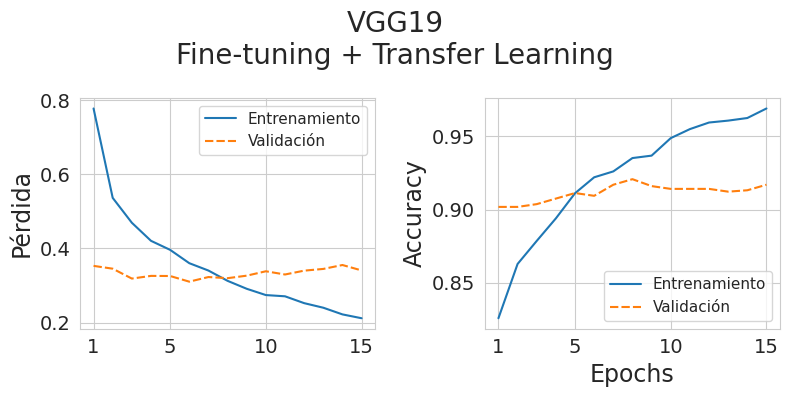

In [ ]:
plot_training_results_classification(
    checkpoint["train_accuracies"],
    checkpoint["val_accuracies"],
    checkpoint["train_losses"],
    checkpoint["val_losses"],
    title="VGG19\nFine-tuning + Transfer Learning")

Representamos la matriz de confusión del mejor modelo encontrado:

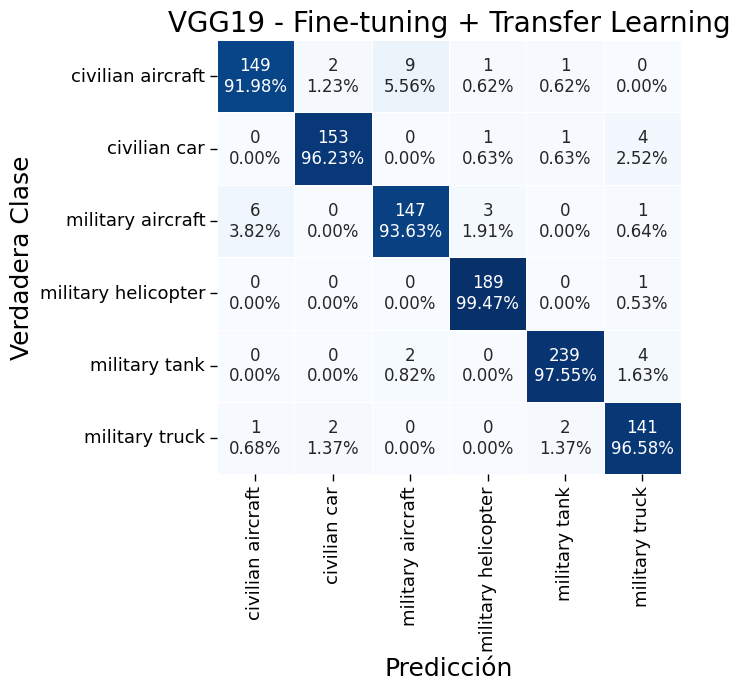

In [ ]:
model_vgg19_best, _, _ = get_model_vgg19(6)
model_vgg19_best.load_state_dict(checkpoint["best_model"]["model_state_dict"])
predictions = predict(model_vgg19_best, val_dataloader)
_ = make_cf_matrix(predictions, val_dataset.y.to_numpy(),
                   label_encoder, "VGG19 - Fine-tuning + Transfer Learning")